In [12]:
import os
# os.environ["PATH"] = "/Library/TeX/texbin:" + os.environ["PATH"]

import numpy as np
from tqdm import tqdm
import time
import agama
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import gridspec
from scipy.stats import ks_2samp
from multiprocessing import Pool, cpu_count
from itertools import product
from multiprocessing import Pool

rcParams.update({
    "text.usetex": True,               # Use LaTeX for text
    "font.family": "serif",            # Use serif fonts
    "font.serif": ["Computer Modern"], # Default LaTeX font
    "axes.labelsize": 14,              # Axis label size
    "font.size": 13,                   # General font size
    "legend.fontsize": 12,             # Legend font size
    "xtick.labelsize": 12,             # X tick label size
    "ytick.labelsize": 12,             # Y tick label size
    "text.latex.preamble": r"\usepackage{amsmath,amssymb}"  # Optional packages
})

agama.setUnits(mass=1, length=1, velocity=1)

In [2]:
def hamiltonBar(t, Omega_b, A, b, v_0=230.):
    """
    Bar that matches the analytic bar in the paper
    Very slow for computation
    """
    coeff = -A*v_0**2/2
    
    def bar_potential(xyz):
        
        phi = np.arctan2(xyz[:,1], xyz[:,0])
        R = np.linalg.norm(xyz[:,0:2], axis=1)
        z = xyz[:,2]
        
        R_CR = v_0 / Omega_b
        pot_R = (R/R_CR)**2 * ((b+1)/(b + R/R_CR))**5

        z_b = 1.0 # scale height
        
        return coeff * np.cos(2*(phi - Omega_b*t)) * pot_R * np.exp(-z**2/(2*z_b**2))
    
    return agama.Potential(bar_potential)


In [3]:
def inertial_to_corotating(cart, t, Omega_p):
    """
    Convert 6-D Cartesian phase-space points from the inertial frame to a
    frame that co-rotates at constant pattern speed Omega_p (rad per time unit)
    about the +z axis.
    """
    cart  = np.asarray(cart)
    t     = np.asarray(t)
    theta = Omega_p * t             

    # rotation matrix elements
    c = np.cos(theta)
    s = np.sin(theta)

    # split and broadcast components
    x, y, z, vx, vy, vz = np.moveaxis(cart, -1, 0) # shapes match theta

    # positions
    x_r =  x*c + y*s
    y_r = -x*s + y*c
    z_r =  z                                  

    # velocities
    vx_eff = vx + Omega_p * y
    vy_eff = vy - Omega_p * x

    vx_r =  vx_eff*c + vy_eff*s
    vy_r = -vx_eff*s + vy_eff*c
    vz_r =  vz

    corot = np.stack((x_r, y_r, z_r, vx_r, vy_r, vz_r), axis=-1)
    return corot


In [4]:
time_end = 8.0 # total time in Gyr
trajsize = int(time_end)*2**10 # output trajectory length

times    = np.linspace(0, time_end, trajsize) # array of timesteps
phi_bar0 = 0.0 # initial bar orientation
omega_p  = 35.0 # pattern speed of the bar

phi_bar_array = phi_bar0 + omega_p*times # array of bar orientations

In [5]:
# Ferrers bar potential
bar = agama.Potential(type='Ferrers',
                      mass=10**8.9,        
                      scaleRadius=4,               
                      axisRatioY=2.0/3.5,    
                      axisRatioZ=1.0/3.5,    
                      rotation=np.column_stack([times, phi_bar_array])
)

# analytic potential 
ham_bar_one = hamiltonBar(0, omega_p, 0.02, 0.28, 230)
ham_bar = agama.Potential(potential=ham_bar_one, rotation=np.column_stack([times, phi_bar_array]))

# halo potential
halo = agama.Potential(type='Logarithmic',
                       v0=230.0,           # asymptotic circular speed, km/s
                       scaleRadius=0.1,    # core radius, kpc
                       axisRatioY=1.0,     # p = 1 for spherical
                       axisRatioZ=1.0)     # q = 1 for spherical

# TOTAL Potential used in simulations below
pot = agama.Potential(halo, bar)

/var/folders/jb/7f0bq_sx0435s1wvlt2yfkcr0000gn/T/ipykernel_19081/2698710029.py:21: RuntimeWarning: symmetry is not provided, some methods will not be available
  return agama.Potential(bar_potential)


/var/folders/jb/7f0bq_sx0435s1wvlt2yfkcr0000gn/T/ipykernel_19081/2407603085.py:8: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(r, np.sqrt(-r*ham_bar.force(points)[:,0]), label='Analytic bar')


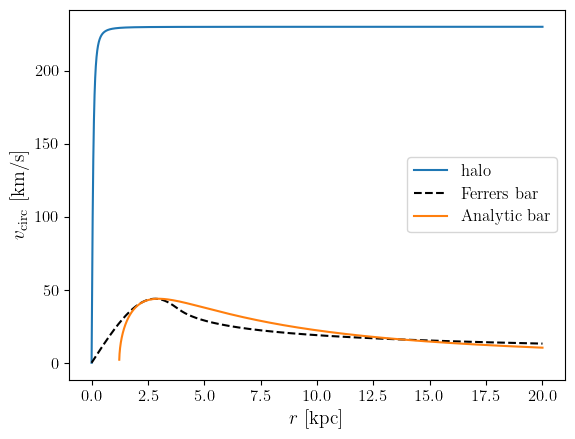

In [6]:
# Plot rotation curves for comparison of potentials

r = np.linspace(0,20, 5000)
points = np.column_stack((r, r*0, r*0)) # a N × 3 array

plt.plot(r, np.sqrt(-r*halo.force(points)[:,0]), label='halo')
plt.plot(r, np.sqrt(-r*bar.force(points)[:,0]), label='Ferrers bar', c='k', linestyle='dashed')
plt.plot(r, np.sqrt(-r*ham_bar.force(points)[:,0]), label='Analytic bar')

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$v_{\rm circ}$ [km/s]')

plt.legend()
plt.show()

In [7]:
# circular speed
def vcirc(pot, R):
    acc = pot.force(np.array([[R,0.0,0.0]]))[0]
    return np.sqrt(R * (-acc[0]))

# epicyclic frequency via finite differences
def kappa(pot, R):
    # epicyclic: κ² = R d(Ω²)/dR + 4 Ω²
    dR = 1e-4 * max(R,1e-2)
    Ω  = vcirc(pot, R)/R
    Ωp = vcirc(pot, R + dR)/(R + dR)
    dΩ2 = (Ωp**2 - Ω**2)/dR
    return np.sqrt(R * dΩ2 + 4 * Ω**2)

# root-find resonance radius for (m:n)
def find_resonance(pot, m, n, Rmin=0.1, Rmax=50.0):
    f = lambda R: m*(vcirc(pot,R)/R - omega_p) - n*kappa(pot,R)
    return brentq(f, Rmin, Rmax)

In [8]:
# We're in co-rotation resonance only, so m=2, n=0
m, n = 2, 0

# find resonance radius and velocity
R_res = find_resonance(pot, m, n)
Vc_res = vcirc(pot, R_res)

# set initial conditions based on these conditions
ic = np.array([0.0, R_res, 0.0, -Vc_res, 0.0, 0.0])

# integrate orbits of resonant star
orbit = agama.orbit(potential=pot, ic=ic, timestart=0, time=time_end, trajsize=trajsize)

# extract trajectory of resonant star
posvels_inert = orbit[1]
times   = orbit[0]
posvels_corot = inertial_to_corotating(posvels_inert, times, omega_p)

# Jacobi in the unperturbed case
L      = np.cross(posvels_inert[:,0:3], posvels_inert[:,3:6])
Lz     = L[:,-1]
E      = 0.5*np.sum(posvels_inert[:,3:6]**2, axis=1) + pot.potential(posvels_corot[:,0:3])
EJ     = E - omega_p*Lz

x, y = posvels_corot[:,0], posvels_corot[:,1]
R = np.hypot(x, y)
phi = np.unwrap(np.arctan2(y, x))

# find pericenters (local minima of R)
# simple finite-difference
dR = np.diff(R)
# pericenter when slope goes from negative to positive
peri_idx = np.where((dR[:-1] < 0) & (dR[1:] > 0))[0] + 1

# build θ_R(t) by linear interpolation between pericenters
theta_R = np.empty_like(times)
for i in range(len(peri_idx)-1):
    i0, i1 = peri_idx[i], peri_idx[i+1]
    dt = times[i1] - times[i0]
    frac = (times[i0:i1] - times[i0]) / dt
    theta_R[i0:i1] = 2*np.pi * frac

# for t beyond last peri, just carry forward linearly
last = peri_idx[-1]
theta_R[last:] = theta_R[last-1] + 2*np.pi*(times[last:]-times[last-1])/(times[last]-times[last-1])

# slow / resonant angle
psi = m*(phi - omega_p*times) - n*theta_R
psi_mod = np.angle(np.exp(1j*psi)) # wrap psi (-pi, pi)

# number of slow angles in the grid
N_phase = 50

# make grid
phi0_grid = np.linspace(-np.pi, np.pi, N_phase, endpoint=False)

# find indices
phase_indices = []
for phi0 in phi0_grid:
    # difference between current ψ and target φ0, mod 2π, in [-π, π]
    dphi = np.angle(np.exp(1j*(psi_mod - phi0)))
    idx  = np.argmin(np.abs(dphi))
    phase_indices.append(idx)

In [9]:
def one_simulation(
        subhalo_mass, 
        subhalo_impact, 
        subhalo_velocity
        ):

    # containers for per-phase results
    delta_EJ_sim_list  = []
    delta_EJ_ana_list  = []
    delta_Is_sim_list  = []
    delta_Is_ana_list  = []

    # fixed subhalo parameters
    mass_sh  = subhalo_mass
    scale_sh = 1.6*(mass_sh / 1e8)**0.5
    b        = subhalo_impact
    vz0      = subhalo_velocity
    v_sub    = np.array([0.0, 0.0, vz0])
    
    N_steps  = int(time_end * 2**8)   # as before
    times_sh = times.copy()

    for idx_phase in phase_indices:

        # star position/velocity at the chosen phase
        r_star = posvels_inert[idx_phase, :3]
        v_star = posvels_inert[idx_phase, 3:]
        t_enc  = times[idx_phase]

        # relative velocity at closest approach (analytic part)
        v_rel_vec = v_sub - v_star           
        v_rel     = np.linalg.norm(v_rel_vec)
        u_hat     = v_rel_vec / v_rel

        # construct a unit vector perpendicular to u_hat
        seed = np.array([1.0, 0.0, 0.0])
        if np.abs(np.dot(seed, u_hat)) > 0.9:
            seed = np.array([0.0, 1.0, 0.0])

        b_hat = np.cross(u_hat, seed)
        b_hat /= np.linalg.norm(b_hat)

        # impact-parameter vector (perpendicular to v_rel)
        b_vec = b * b_hat

        # set the subhalo position at the time of closest approach t0
        r_sub0 = r_star + b_vec

        # time offset from encounter
        dt = times_sh - t_enc

        # subhalo trajectory in Galactocentric frame
        xs = r_sub0[0] + v_sub[0] * dt
        ys = r_sub0[1] + v_sub[1] * dt
        zs = r_sub0[2] + v_sub[2] * dt

        traj_sub = np.vstack([
            xs, ys, zs,
            np.full_like(xs, v_sub[0]),
            np.full_like(ys, v_sub[1]),
            np.full_like(zs, v_sub[2])
        ]).T

        #vxs = np.zeros(N_steps)
        #vys = np.zeros(N_steps)
        #vzs = np.full(N_steps, vz0)

        #traj_sub = np.vstack([xs, ys, zs, vxs, vys, vzs]).T

        # component perpdendicular to v_rel
        b_perp_vec = b_vec
        b_perp     = np.linalg.norm(b_perp_vec)

        if b_perp == 0:
            delta_v_vec = np.zeros(3)
        else:
            delta_v_vec = (
                2 * agama.G * mass_sh
                / (v_rel * (scale_sh**2 + b_perp**2))
            ) * b_perp_vec

        # subhalo potential
        dm_subhalo = agama.Potential(
            type='Plummer', mass=mass_sh,
            scaleRadius=scale_sh,
            center=np.vstack((times_sh, traj_sub[:,:3].T)).T
        )
        pot_pert = agama.Potential(pot, dm_subhalo)

        # integrate star in perturbed potential with same IC
        orbit_pert = agama.orbit(
            potential=pot_pert,
            ic=ic,
            timestart=0,
            time=time_end,
            trajsize=trajsize
        )

        posvels_inert_pert = orbit_pert[1]
        posvels_corot_pert = inertial_to_corotating(posvels_inert_pert, times, omega_p)

        # simulated Jacobi integral in the PERTURBED case
        L_pert  = np.cross(posvels_inert_pert[:,0:3], posvels_inert_pert[:,3:6])
        Lz_pert = L_pert[:,-1]
        E_pert  = 0.5*np.sum(posvels_inert_pert[:,3:6]**2, axis=1) + pot.potential(posvels_corot_pert[:,0:3])
        EJ_pert = E_pert - omega_p*Lz_pert

        # simulated change in Jacobi integral (and slow action)
        delta_EJ_sim = np.abs(EJ[-1]  - EJ_pert[-1])
        delta_Is_sim = np.abs(Lz[idx_phase]  - Lz_pert[idx_phase]) / 2

        # change in Lz from the impulse
        delta_Lz_analytical = np.cross(r_star, delta_v_vec)[2]

        # slow action I_s ≈ Lz / m  (where we fix m=2)
        delta_Is_analytical = np.abs(delta_Lz_analytical) / 2.0

        # change in Jacobi integral: ΔEJ = v·Δv + ½|Δv|² − Ω_p ΔLz
        delta_EJ_analytical = (
            np.dot(v_star, delta_v_vec)
            + 0.5*np.dot(delta_v_vec, delta_v_vec)
            - omega_p * delta_Lz_analytical
        )

        # accumulate
        delta_EJ_sim_list.append(delta_EJ_sim)
        delta_EJ_ana_list.append(delta_EJ_analytical)
        delta_Is_sim_list.append(delta_Is_sim)
        delta_Is_ana_list.append(delta_Is_analytical)
    
    return [
        np.mean(delta_EJ_sim_list),
        np.mean(delta_EJ_ana_list),
        np.mean(delta_Is_sim_list),
        np.mean(delta_Is_ana_list),
    ]

In [10]:
# Original arrays for b,v,M
impact_list   = np.linspace(0, 50, 25)
velocity_list = np.linspace(0, 500, 25)
mass_list     = np.logspace(5, 10, 6)

impact_list   = np.linspace(0, 10, 5)
velocity_list = np.linspace(0, 100, 5)
mass_list     = np.logspace(5, 10, 6)


# Create a grid of the inputs
M, B, V = np.meshgrid(mass_list, impact_list, velocity_list, indexing='ij')

count_max = len(mass_list) * len(impact_list) * len(velocity_list)

# Initialise the empty simulation results grid
dE_sim = np.zeros_like(M)
dE_ana = np.zeros_like(M)
dv_sim = np.zeros_like(M)
dv_ana = np.zeros_like(M)

with tqdm(total=count_max, desc="Running simulations") as pbar:
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            for k in range(M.shape[2]):

                result = one_simulation(
                    subhalo_mass=M[i, j, k],
                    subhalo_impact=B[i, j, k],
                    subhalo_velocity=V[i, j, k],
                )
                dE_sim[i,j,k], dE_ana[i,j,k] = result[0], result[1]
                dv_sim[i,j,k], dv_ana[i,j,k] = result[2], result[3]

                pbar.update(1)

Running simulations: 100%|██████████| 150/150 [02:06<00:00,  1.19it/s]


In [ ]:
# Original arrays for b, v, M
# impact_list   = np.linspace(0, 50, 25)
# velocity_list = np.linspace(0, 500, 25)
# mass_list     = np.logspace(5, 10, 6)



# Create a grid of the inputs
M, B, V = np.meshgrid(mass_list, impact_list, velocity_list, indexing='ij')

# Initialise the empty simulation results grid
dE_sim = np.zeros_like(M)
dE_ana = np.zeros_like(M)
dv_sim = np.zeros_like(M)
dv_ana = np.zeros_like(M)

indices = list(np.ndindex(M.shape))

def worker(idx):
    i, j, k = idx
    result = one_simulation(
        subhalo_mass     = M[i, j, k],
        subhalo_impact   = B[i, j, k],
        subhalo_velocity = V[i, j, k],
    )
    dE_s, dE_a, dv_s, dv_a = result
    return i, j, k, dE_s, dE_a, dv_s, dv_a

# ---- timing starts here ----
t0 = time.perf_counter()

with Pool() as pool:  # Pool(processes=N) if you want to fix number of cores
    for i, j, k, dE_s, dE_a, dv_s, dv_a in tqdm(
        pool.imap_unordered(worker, indices),
        total=len(indices),
        desc="Running simulations (parallel)",
    ):
        dE_sim[i, j, k] = dE_s
        dE_ana[i, j, k] = dE_a
        dv_sim[i, j, k] = dv_s
        dv_ana[i, j, k] = dv_a

t1 = time.perf_counter()
print(f"Parallel run took {t1 - t0:.2f} s")
# ---- timing ends here ----


Process SpawnPoolWorker-1:
Process SpawnPoolWorker-2:
Process SpawnPoolWorker-3:
Process SpawnPoolWorker-4:
Process SpawnPoolWorker-5:
Process SpawnPoolWorker-6:
Process SpawnPoolWorker-7:
Process SpawnPoolWorker-8:
Process SpawnPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/op

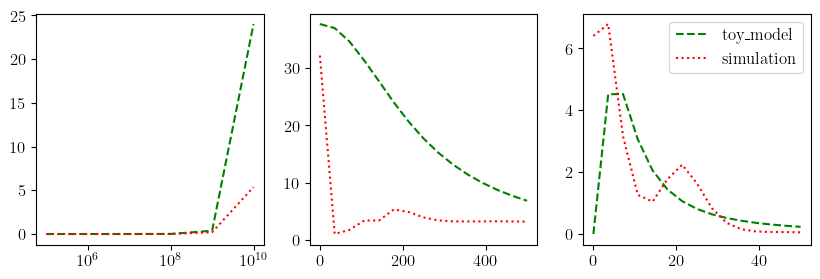

In [157]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

for axis in (ax1, ax2, ax3):
    axis.set_rasterization_zorder(10)
ax1.set_xscale('log')

ax1.plot(mass_list, dE_ana[:,10,5], label='toy_model', linestyle='--', color='green')
ax1.plot(mass_list, dE_sim[:,10,5], label='simulation', linestyle=':', color='red')

ax2.plot(velocity_list, dE_ana[5,10,:], label='toy_model', linestyle='--', color='green')
ax2.plot(velocity_list, dE_sim[5,10,:], label='simulation', linestyle=':', color='red')


ax3.plot(impact_list, dE_ana[4,:,4], label='toy_model', linestyle='--', color='green')
ax3.plot(impact_list, dE_sim[4,:,4], label='simulation', linestyle=':', color='red')

plt.legend()
plt.show()

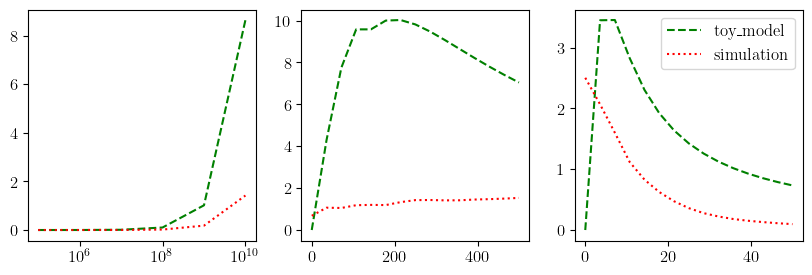

In [159]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

for axis in (ax1, ax2, ax3):
    axis.set_rasterization_zorder(1-1)
ax1.set_xscale('log')

ax1.plot(mass_list, dv_ana[:,10,10], label='toy_model', linestyle='--', color='green')
ax1.plot(mass_list, dv_sim[:,10,10], label='simulation', linestyle=':', color='red')

ax2.plot(velocity_list, dv_ana[5,10,:], label='toy_model', linestyle='--', color='green')
ax2.plot(velocity_list, dv_sim[5,10,:], label='simulation', linestyle=':', color='red')

ax3.plot(impact_list, dv_ana[4,:,10], label='toy_model', linestyle='--', color='green')
ax3.plot(impact_list, dv_sim[4,:,10], label='simulation', linestyle=':', color='red')

plt.legend()
plt.show()

In [160]:
mass_vals = np.log10(np.array([mass_list[0],
                               mass_list[1],
                               mass_list[2],
                               mass_list[3],
                               mass_list[4],
                               mass_list[5]]))

In [161]:
# Comprison 
def comparison_plot(ax, a1, a2, x_vals, y_vals, title=""):
    diff = (a2 - a1) / a1
    extent = [x_vals.min(), x_vals.max(), y_vals.min(), y_vals.max()]
    im = ax.imshow(diff, cmap="bwr", vmin=-1, vmax=1,
                   extent=extent, origin="lower", aspect="auto")
    ax.set_title(title, fontsize=10)
    ax.set_ylabel(r"$v_{\rm rel}$ [km/s]")
    ax.set_xlabel(r"$b$ [kpc]")
    ax.tick_params(direction="in")
    ax.label_outer()
    ax.text(0.05, 0.9, rf"$\log M = {np.round(mass_vals[i],2)}$",
            transform=ax.transAxes, fontsize=12, color="black",
            ha="left", va="top",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3"))
    return im

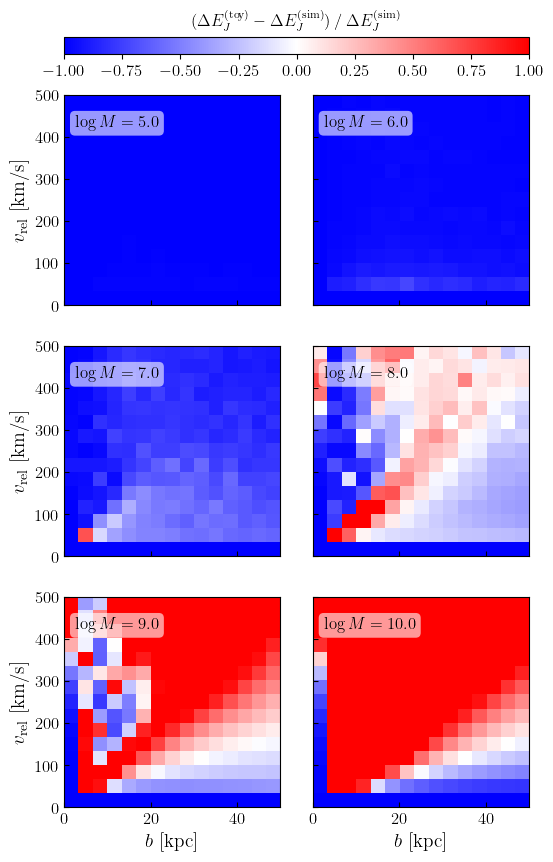

In [162]:
# Example coordinate values
x_vals = impact_list
y_vals = velocity_list

# Generate random example data
arrays = [(dE_sim[0], dE_ana[0]),
          (dE_sim[1], dE_ana[1]),
          (dE_sim[2], dE_ana[2]),
          (dE_sim[3], dE_ana[3]),
          (dE_sim[4], dE_ana[4]),
          (dE_sim[5], dE_ana[5])]

# --- Layout: top row colorbar, then 3x2 of plots ---
fig = plt.figure(figsize=(6, 10))
gs = gridspec.GridSpec(
    4, 2,
    height_ratios=[0.08, 1, 1, 1],  # small top band for colorbar
    hspace=0.25, wspace=0.15
)

# Colorbar axis (spans both columns, top-middle)
cax = fig.add_subplot(gs[0, :])

# 3x2 plot axes (rows 1..3, cols 0..1)
axes = [fig.add_subplot(gs[r, c]) for r in range(1, 4) for c in range(2)]

# Plot each panel
for i, (a1, a2) in enumerate(arrays):
    comparison_plot(axes[i], a1, a2, x_vals, y_vals)

# Add colorbar in its own axes
norm = plt.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap="bwr", norm=norm)
cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
cbar.ax.set_title(
    r'$(\Delta E_J^{\rm (toy)} - \Delta E_J^{\rm (sim)}) \: / \: \Delta E_J^{\rm (sim)}$',
    pad=8, fontsize=12
)

#plt.savefig('deltaEJ_compare.pdf', dpi=400, bbox_inches='tight')
plt.show()

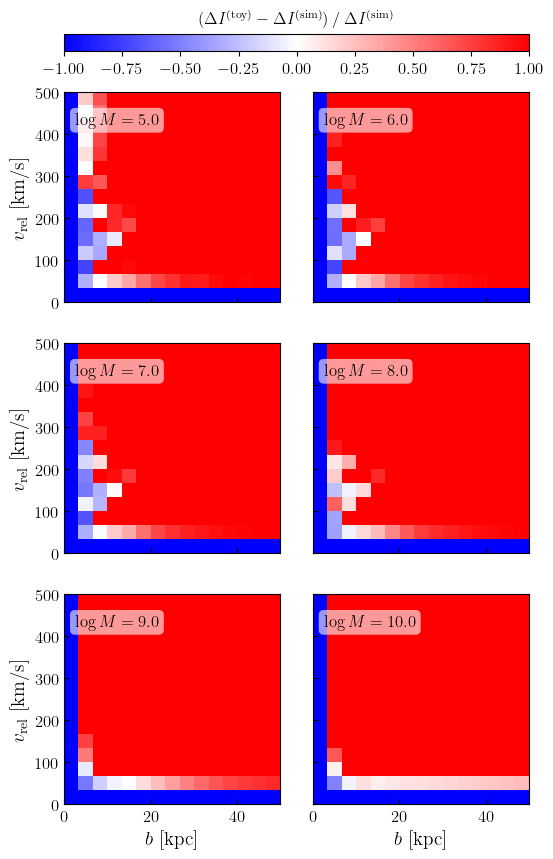

In [163]:
# Example coordinate values
x_vals = impact_list
y_vals = velocity_list

# Generate random example data
arrays = [(dv_sim[0], dv_ana[0]),
          (dv_sim[1], dv_ana[1]),
          (dv_sim[2], dv_ana[2]),
          (dv_sim[3], dv_ana[3]),
          (dv_sim[4], dv_ana[4]),
          (dv_sim[5], dv_ana[5])]

# --- Layout: top row colorbar, then 3x2 of plots ---
fig = plt.figure(figsize=(6, 10))
gs = gridspec.GridSpec(
    4, 2,
    height_ratios=[0.08, 1, 1, 1],  # small top band for colorbar
    hspace=0.25, wspace=0.15
)

# Colorbar axis (spans both columns, top-middle)
cax = fig.add_subplot(gs[0, :])

# 3x2 plot axes (rows 1..3, cols 0..1)
axes = [fig.add_subplot(gs[r, c]) for r in range(1, 4) for c in range(2)]

# Plot each panel
for i, (a1, a2) in enumerate(arrays):
    comparison_plot(axes[i], a1, a2, x_vals, y_vals)

# Add colorbar in its own axes
norm = plt.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap="bwr", norm=norm)
cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
cbar.ax.set_title(
    r'$(\Delta I^{\rm (toy)} - \Delta I^{\rm (sim)}) \: / \: \Delta I^{\rm (sim)}$',
    pad=8, fontsize=12
)

#plt.savefig('deltaV_compare.pdf', dpi=400, bbox_inches='tight')
plt.show()

In [167]:
def compare_grids(A: np.ndarray, B: np.ndarray, exceed_factor: float = 1.2):
    """
    Compare two 2D grids A and B with various overprediction metrics.

    Parameters
    ----------
    A : np.ndarray
        Grid from the 'overpredicting' model
    B : np.ndarray
        Reference grid
    exceed_factor : float
        Threshold factor for exceedance ratio (default 1.2 means 20% higher)

    Returns
    -------
    stats : dict
        Dictionary of summary statistics
    """

    # Flatten grids for convenience
    A_flat = A.ravel()
    B_flat = B.ravel()
    N = A_flat.size

    # Differences
    diff = A_flat - B_flat

    # Pointwise error metrics
    mean_bias = np.mean(diff)
    mae = np.mean(np.abs(diff))
    rmse = np.sqrt(np.mean(diff**2))

    # Relative measures
    with np.errstate(divide='ignore', invalid='ignore'):
        relative_errors = np.where(B_flat != 0, diff / B_flat, np.nan)
    relative_bias = np.nansum(diff) / np.nansum(B_flat) if np.nansum(B_flat) != 0 else np.nan

    # Threshold-based measures
    overprediction_fraction = np.mean(A_flat > B_flat)
    exceedance_ratio = np.mean(A_flat > exceed_factor * B_flat)

    # Aggregate comparisons
    total_A = np.sum(A_flat)
    total_B = np.sum(B_flat)
    total_ratio = total_A / total_B if total_B != 0 else np.nan
    correlation = np.corrcoef(A_flat, B_flat)[0,1]

    # Distributional differences
    ks_stat, ks_pval = ks_2samp(A_flat, B_flat)
    mean_positive_bias = np.mean(np.clip(diff, a_min=0, a_max=None))

    stats = {
        "Mean Bias": mean_bias,
        "Mean Absolute Error": mae,
        "RMSE": rmse,
        "Relative Bias": relative_bias,
        "Mean Relative Error (ignoring zeros)": np.nanmean(relative_errors),
        "Overprediction Fraction": overprediction_fraction,
        f"Exceedance Ratio (>{exceed_factor}x)": exceedance_ratio,
        "Total A": total_A,
        "Total B": total_B,
        "Total Ratio A/B": total_ratio,
        "Correlation": correlation,
        "KS Statistic": ks_stat,
        "KS p-value": ks_pval,
        "Mean Positive Bias": mean_positive_bias,
    }

    #return stats
    return overprediction_fraction




In [172]:
metric_dE = np.zeros(len(mass_list))
metric_dI = np.zeros(len(mass_list))

for i in range(len(mass_list)):
    metric_dE[i] = compare_grids(dE_sim[i], dE_ana[i])
    metric_dI[i] = compare_grids(dv_sim[i], dv_ana[i])

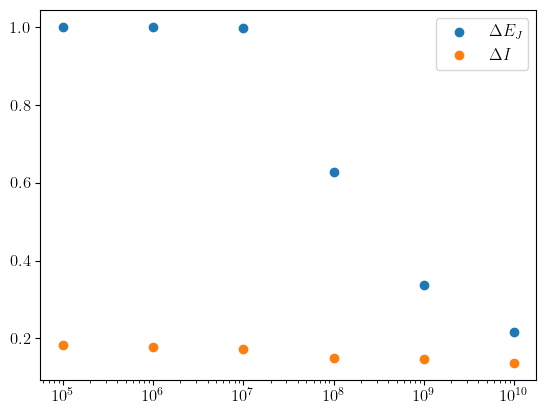

In [180]:
indices = np.arange(0, len(mass_list))

plt.scatter(10**(5+indices), metric_dE, label=r'$\Delta E_J$')
plt.scatter(10**(5+indices), metric_dI, label=r'$\Delta I$')
plt.xscale('log')
#plt.yscale('log')

#plt.ylim(1e-1, 1.05)
plt.legend()